# Image Resizing using PYNQ-ZU and Vivado Hardware Accelerator

This notebook demonstrates how to use a custom hardware accelerator for resizing images on the PYNQ-ZU platform using Vivado. We will use a DMA (Direct Memory Access) for transferring image data and a custom resizing accelerator implemented in hardware.

## Prerequisites

- PYNQ-ZU platform
- Vivado and Vitis HLS for creating custom IP
- PYNQ Python library installed
- A bitstream file (`resizer.bit`) containing the hardware design

## Step 1: Import Required Libraries

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pynq import allocate, Overlay

 ## Step 2: Load the Overlay
Load the bitstream file containing the hardware design onto the PYNQ-ZU.

In [2]:
resize_design = Overlay("resizer.bit")

/usr/local/share/pynq-venv/lib/python3.8/site-packages/pynq/ps.py:462: UserWarning: Setting frequency to the closest possible value 98.8879MHz.
  warnings.warn(


## Step 3: Set Up DMA and Resizer IP
Configure the DMA and resizer IPs from the loaded overlay.

In [3]:
dma = resize_design.axi_dma_0
resizer = resize_design.resize_accel_0

## Step 4: Load and Display the Original Image
Load the image to be resized and display its dimensions and content.

In [4]:
image_path = "pynq.jpeg"
original_image = Image.open(image_path)

Image size: 1453x1284 pixels.


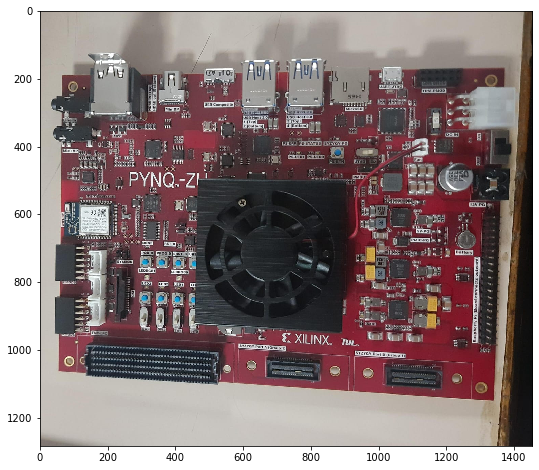

In [5]:
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size*2)

old_width, old_height = original_image.size
print("Image size: {}x{} pixels.".format(old_width, old_height))
# plt.figure(figsize=(12, 10));
_ = plt.imshow(original_image)

## Step 5: Set Resize Factor and Compute New Dimensions
Define the resize factor and calculate the dimensions of the resized image.

In [6]:
resize_factor = 4
new_width = int(old_width/resize_factor)
new_height = int(old_height/resize_factor)

## Step 6: Allocate Buffers
Allocate memory buffers for the input and output images.

In [7]:
in_buffer = allocate(shape=(old_height, old_width, 3), 
                           dtype=np.uint8, cacheable=1)
out_buffer = allocate(shape=(new_height, new_width, 3), 
                            dtype=np.uint8, cacheable=1)

## Step 7: Load Image into Input Buffer
Copy the original image data into the input buffer.

In [8]:
in_buffer[:] = np.array(original_image)

## Step 8: Define the Function to Run the Hardware Kernel
Define a function to handle the DMA transfer and execution of the hardware accelerator.

In [9]:
def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    resizer.write(0x00,0x81) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()

## Step 9: Set Resizer Parameters
Set the source and destination dimensions for the resizer IP.

In [10]:
resizer.register_map.src_rows = old_height
resizer.register_map.src_cols = old_width
resizer.register_map.dst_rows = new_height
resizer.register_map.dst_cols = new_width

## Step 10: Run the Kernel
Execute the kernel function to perform the resizing.

In [11]:
run_kernel()
resized_image = Image.fromarray(out_buffer)

## Step 11: Display the Resized Image
Convert the output buffer to an image and display it.

Image size: 363x321 pixels.


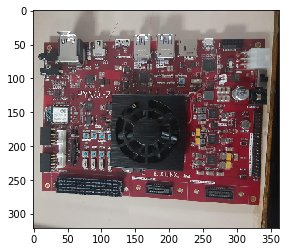

In [12]:
print("Image size: {}x{} pixels.".format(new_width, new_height))
# plt.figure(figsize=(12, 10));
_ = plt.imshow(resized_image)

## Step 12: Measure Kernel Execution Time
Use the timeit magic command to measure the time taken to execute the kernel.

In [13]:
%%timeit
run_kernel()
resized_image = Image.fromarray(out_buffer)

20.3 ms ± 26.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Step 13: Clean Up
Delete the allocated buffers to free up memory.

In [14]:
del in_buffer
del out_buffer